# Build Hybrid MgSiO3 Model using multiple datasets
* Combine MD simulations of Spera et al. (2011) and deKoker(2009) with experimental 1 bar measurements to develop best overall model
* Use high resolution model to Spera dataset as prior for thermal and gamma components
* Need to adjust parameters to account for altered V0 value (for both gamma and RT coef model)
* refit V0, K0, KP0, E0
* compare resulting ambient properties to experiment-based models of Ghiorso and Lange

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
import pickle

import xmeos
from xmeos import models
from xmeos import datamod
CONSTS = models.CONSTS
import copy

In [2]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)
    
datasets = analysis['datasets']
param_tex_str = analysis['param_tex_str']
eos_electronic = analysis['eos_electronic']




In [3]:
data = datasets['deKoker2009']
data_S11 = datasets['Spera2011']
# View data tables
tbl = data['table']
tbl

,V,T,P,E,trust,Verr,T_label,V_label
0,14.210892,2000,-1.058632,-7.228171,True,0,2000.0,14.21
1,12.918993,2000,1.302932,-7.240976,True,0,2000.0,12.92
2,11.627094,2000,3.583062,-7.232767,True,0,2000.0,11.63
3,10.335194,2000,10.097720,-7.256082,True,0,2000.0,10.34
4,15.502791,3000,-0.599026,-6.850816,True,0,3000.0,15.50
5,14.210892,3000,-0.022602,-6.901380,True,0,3000.0,14.21
6,12.918993,3000,2.589749,-6.912718,True,0,3000.0,12.92
7,11.627094,3000,5.039047,-6.911158,True,0,3000.0,11.63
8,10.335194,3000,13.269362,-6.925664,True,0,3000.0,10.34
9,9.043295,3000,26.953859,-6.859135,True,0,3000.0,9.04


## Visualize FPMD data of deKoker et al. (2009)

In [4]:
datamodel_S11 = analysis['datamodel']
eos_mod = copy.deepcopy(datamodel_S11['eos_mod'])
datamodel = datamod.init_datamodel(data, eos_mod)

eos_mod.apply_electronic=True
# Set colorbar temperature properties
#cmap = plt.get_cmap('coolwarm',len(data['T_labels']))
cmap = plt.get_cmap('coolwarm')

delT = np.diff(data['T_labels'])[0]


dE0 = 13.75
E0 = eos_mod.get_params()['E0'] + dE0
eos_mod.set_param_values(E0,param_names='E0')

V0 = eos_mod.get_params()['V0']

eos_electronic.set_param_values(param_names=['V0'], param_values=V0)



Tlbl = data['T_labels']
# cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]

Vmod = V0*np.linspace(.35,1.2,1001)

In [5]:
P_electron = eos_electronic.press(tbl['V'],tbl['T'])
E_electron = eos_electronic.energy(tbl['V'],tbl['T'])

tbl['P'] -= P_electron
tbl['E'] -= E_electron

<IPython.core.display.Javascript object>


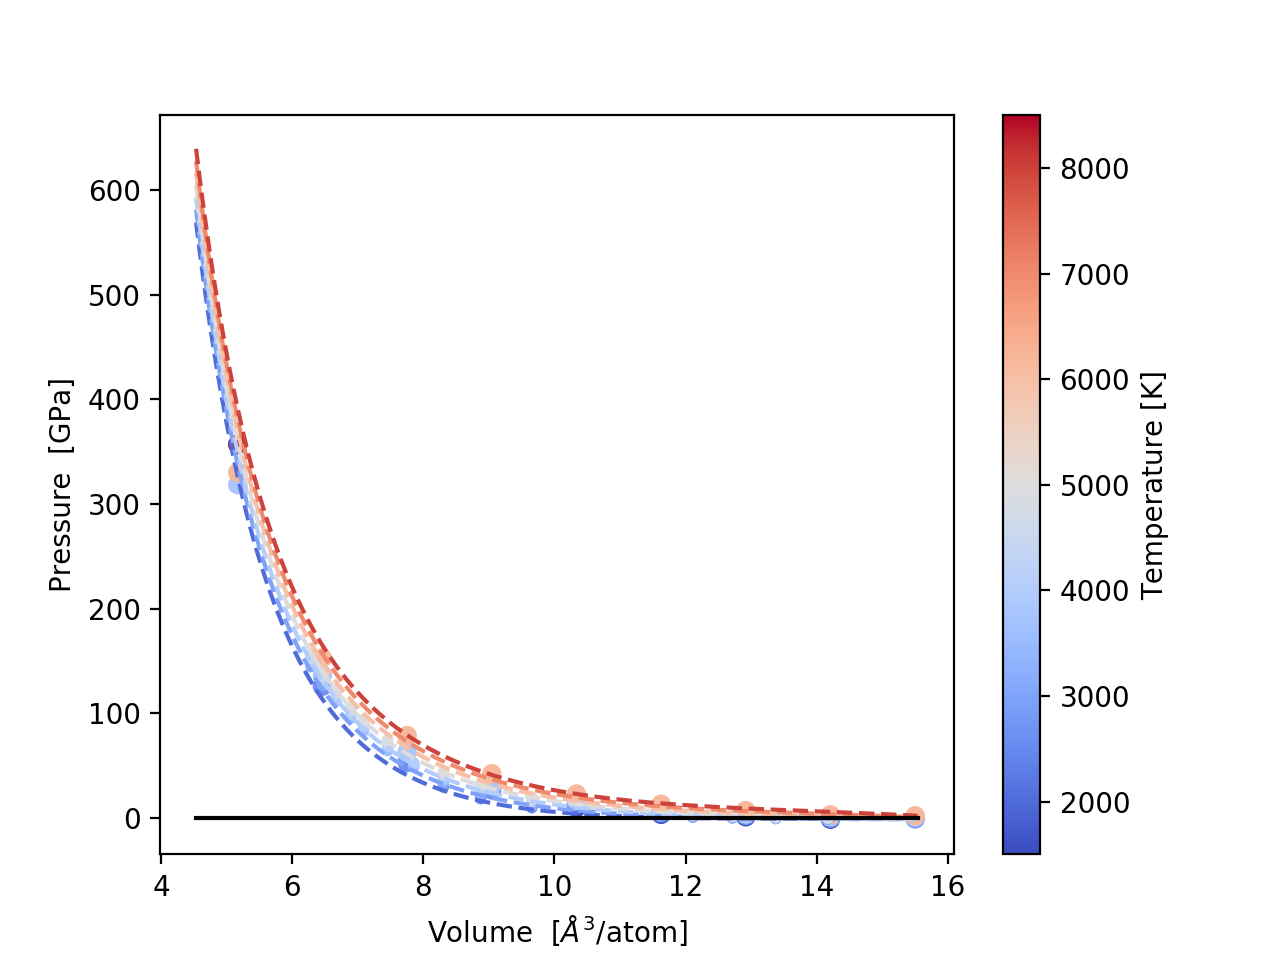

In [6]:

tbl_S11 = data_S11['table']

plt.figure()
plt.scatter(tbl['V'],tbl['P'],c=tbl['T'], cmap=cmap)
plt.scatter(tbl_S11['V'],tbl_S11['P'],c=tbl_S11['T'], s=10, cmap=cmap)

for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.press(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

# plt.ylim(-2,15);
plt.plot(Vmod,0*Vmod,'k-')


<IPython.core.display.Javascript object>


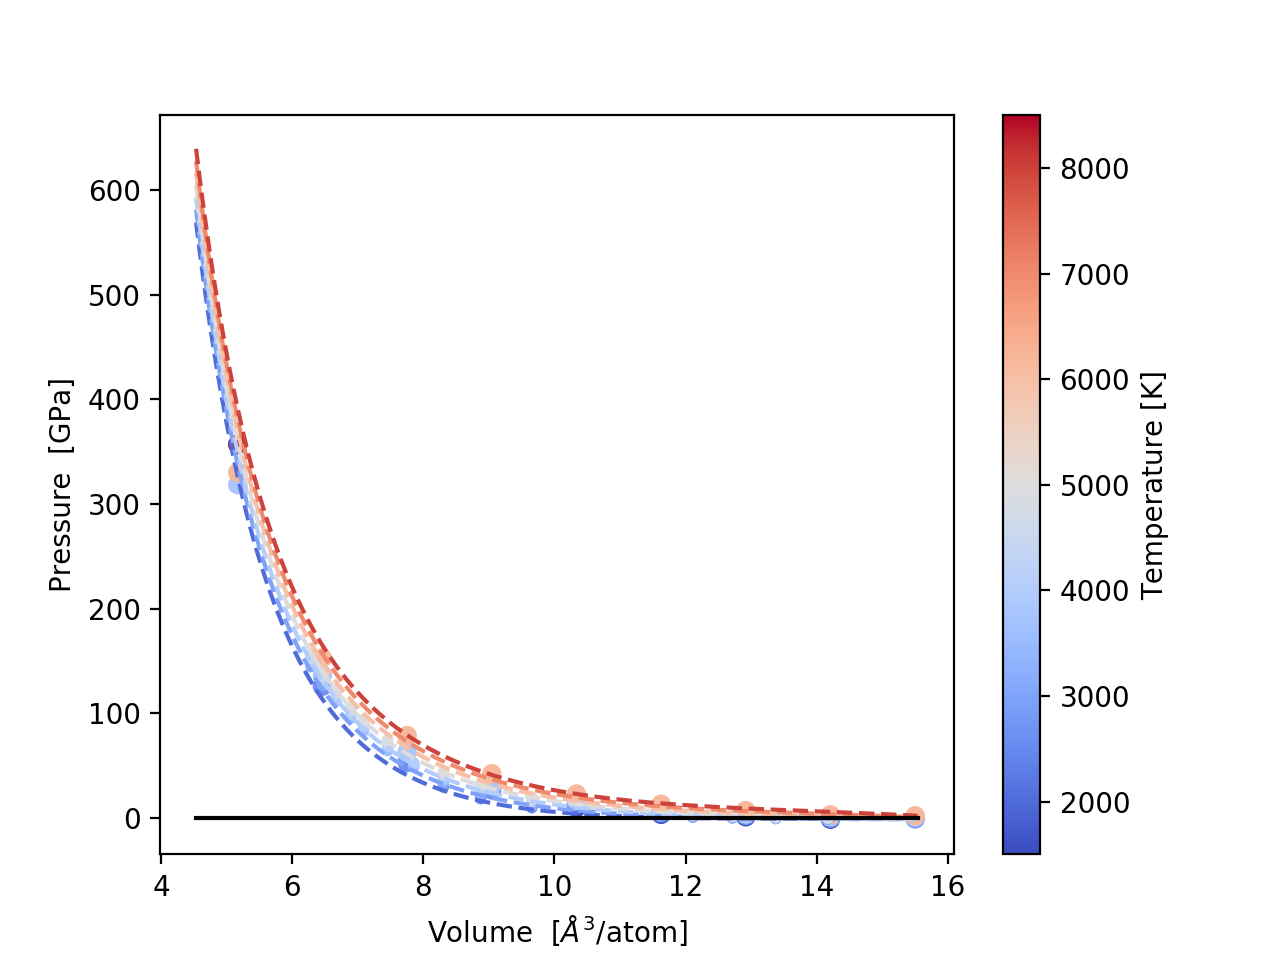

In [7]:
tbl_S11 = data_S11['table']

plt.figure()
plt.scatter(tbl['V'],tbl['P'],c=tbl['T'], cmap=cmap)
plt.scatter(tbl_S11['V'],tbl_S11['P'],c=tbl_S11['T'], s=10, cmap=cmap)

for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.press(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

# plt.ylim(-2,15);
plt.plot(Vmod,0*Vmod,'k-')


In [8]:
eos_mod.apply_electronic=True

<IPython.core.display.Javascript object>


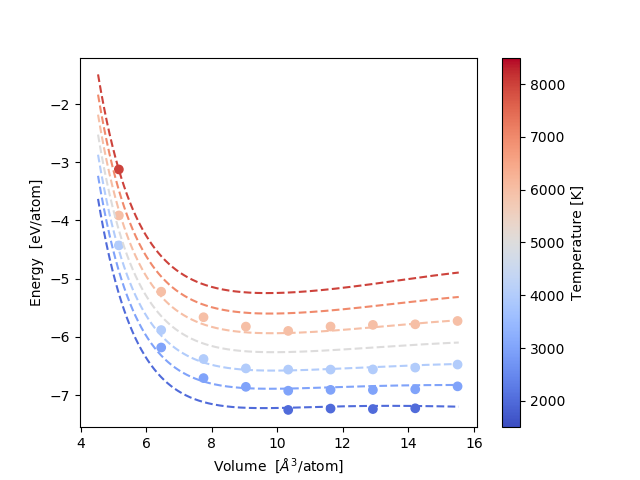

In [9]:


plt.figure()
plt.scatter(tbl['V'],tbl['E'],c=tbl['T'], cmap=cmap)


for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.internal_energy(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

<IPython.core.display.Javascript object>


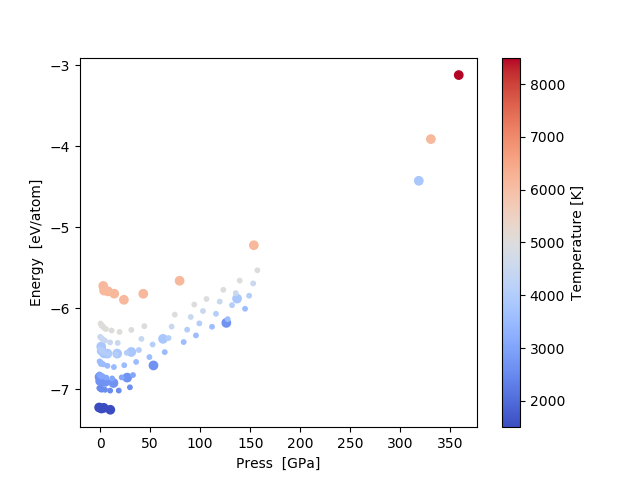

In [10]:
Tplt = [2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000]
cmap = plt.get_cmap('coolwarm',1000)
plt.figure()
plt.scatter(tbl['P'],tbl['E'],c=tbl['T'], cmap=cmap)
plt.scatter(tbl_S11['P'],tbl_S11['E']+dE0,c=tbl_S11['T'], s=10, cmap=cmap)

# for iT in Tplt:
#    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
#    plt.plot(eos_mod.press(Vmod,iT),eos_mod.internal_energy(Vmod,iT),'-',color=icol)
    
plt.xlabel(r'Press  [GPa]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

In [11]:
fit_calcs = ['compress','refstate','gamma']
fix_params = ['S0','Cvlimfac','mexp']
# fix_params = ['S0','Cvlimfac']
datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])

datamod.select_fit_params(datamodel, fit_calcs, fix_params=fix_params)
datamodel['fit_params']

['V0', 'K0', 'KP0', 'E0', 'gamma0', 'gammap0']

In [12]:
datamod.fit(datamodel)
datamod.fit(datamodel, apply_bulk_mod_wt=True)

In [13]:
display('R2fit = ', datamodel['posterior']['R2fit'])
display('Model Residual Error = ', datamodel['posterior']['fit_err'])
display(datamodel['posterior']['param_tbl'])

'R2fit = '

{'E': 0.99506165279789827, 'P': 0.99642202444370487, 'V': 0.99006057793770874}

'Model Residual Error = '

{'E': 0.072312342688057349, 'P': 6.4506748965226643, 'V': 0.33964197172974658}

,name,value,error
0,V0,14.381209,0.121300
1,K0,14.597389,0.938621
2,KP0,6.636853,0.128833
3,E0,-6.872194,0.016935
4,gamma0,0.308593,0.027380
5,gammap0,-1.406772,0.187943


In [27]:
datamodel.keys()

dict_keys(['data', 'eos_mod', 'isthermal', 'err_scale', 'param_names', 'param_isfree', 'fit_params', 'bulk_mod_wt', 'posterior'])

In [30]:
prior = datamodel['posterior']
prior

OrderedDict([('param_names', ['V0', 'K0', 'KP0', 'E0', 'gamma0', 'gammap0']),
             ('param_val',
              array([ 14.38120871,  14.59738908,   6.63685255,  -6.87219408,
                       0.30859262,  -1.4067724 ])),
             ('param_err',
              array([ 0.12130015,  0.93862077,  0.12883259,  0.01693537,  0.02737994,
                      0.1879431 ])),
             ('param_tbl',       name      value     error
              0       V0  14.381209  0.121300
              1       K0  14.597389  0.938621
              2      KP0   6.636853  0.128833
              3       E0  -6.872194  0.016935
              4   gamma0   0.308593  0.027380
              5  gammap0  -1.406772  0.187943),
             ('corr',
              array([[ 1.        , -0.66761573,  0.22369236,  0.10696823, -0.37695475,
                      -0.14276595],
                     [-0.66761573,  1.        , -0.84471243,  0.03031912,  0.30006552,
                      -0.45914838],
           

* prior is used by least squares approach by transforming to eigenbasis and applying normal constraints in that context
* This prior approach is only valid if the posterior and prior estimates are nearly unchanged
* Otherwise, mabye need to adopt monte carlo approach (fixing values to those drawn from prior  and then fitting compress model with uncertainties, and repeating)
* Final assesment made based on Lange or Ghiorso properties at 1bar and 1673 K

In [40]:
corr = prior['corr']
param_err = prior['param_err']
cov = np.dot(param_err[:,np.newaxis],param_err[np.newaxis,:])*corr
cov

array([[  1.47137271e-02,  -7.60112836e-02,   3.49573280e-03,
          2.19740848e-04,  -1.25193850e-03,  -3.25471060e-03],
       [ -7.60112836e-02,   8.81008949e-01,  -1.02146801e-01,
          4.81949280e-04,   7.71149689e-03,  -8.09971240e-02],
       [  3.49573280e-03,  -1.02146801e-01,   1.65978353e-02,
         -3.04108827e-04,  -4.37083336e-04,   1.45495526e-02],
       [  2.19740848e-04,   4.81949280e-04,  -3.04108827e-04,
          2.86806702e-04,   9.71494321e-05,  -1.06822803e-03],
       [ -1.25193850e-03,   7.71149689e-03,  -4.37083336e-04,
          9.71494321e-05,   7.49660891e-04,   2.26438484e-04],
       [ -3.25471060e-03,  -8.09971240e-02,   1.45495526e-02,
         -1.06822803e-03,   2.26438484e-04,   3.53226089e-02]])

In [43]:
np.linalg.inv(cov)

array([[  848.39593023,   183.26345766,   785.62040274,   656.00714749,
         -154.39628767,   195.63666403],
       [  183.26345766,    44.50682046,   199.20093163,   179.71939779,
          -71.84655686,    42.78731721],
       [  785.62040274,   199.20093163,  1003.89478644,   748.46590263,
         -291.13761389,   140.16254214],
       [  656.00714749,   179.71939779,   748.46590263,  5042.74547732,
        -1068.02970219,   323.60771819],
       [ -154.39628767,   -71.84655686,  -291.13761389, -1068.02970219,
         1814.92394419,  -102.98858711],
       [  195.63666403,    42.78731721,   140.16254214,   323.60771819,
         -102.98858711,    97.1642699 ]])

In [45]:
np.linalg.inv(corr)

array([[ 12.48306615,  20.86543214,  12.27721403,   1.34761106,
         -0.51277947,   4.46003208],
       [ 20.86543214,  39.21090711,  24.08836098,   2.85679951,
         -1.84641172,   7.54799498],
       [ 12.27721403,  24.08836098,  16.66248035,   1.63302335,
         -1.02696696,   3.39378306],
       [  1.34761106,   2.85679951,   1.63302335,   1.4462932 ,
         -0.49523395,   1.03000636],
       [ -0.51277947,  -1.84641172,  -1.02696696,  -0.49523395,
          1.3605775 ,  -0.52996588],
       [  4.46003208,   7.54799498,   3.39378306,   1.03000636,
         -0.52996588,   3.4320955 ]])

In [53]:
hess = np.dot(1/param_err[:,np.newaxis],1/param_err[np.newaxis,:])*np.linalg.inv(corr)
hess

array([[  848.39593023,   183.26345766,   785.62040274,   656.00714749,
         -154.39628767,   195.63666403],
       [  183.26345766,    44.50682046,   199.20093163,   179.71939779,
          -71.84655686,    42.78731721],
       [  785.62040274,   199.20093163,  1003.89478644,   748.46590263,
         -291.13761389,   140.16254214],
       [  656.00714749,   179.71939779,   748.46590263,  5042.74547732,
        -1068.02970219,   323.60771819],
       [ -154.39628767,   -71.84655686,  -291.13761389, -1068.02970219,
         1814.92394419,  -102.98858711],
       [  195.63666403,    42.78731721,   140.16254214,   323.60771819,
         -102.98858711,    97.1642699 ]])

In [114]:
U,S,V = np.linalg.svd(cov)
eigvecs = U
eigval = S
eigerr = np.sqrt(eigval)

In [108]:

np.dot(cov,U[:,3])/S[3]

array([ 0.55120502,  0.11322625,  0.54721909, -0.04577874,  0.61253758,
        0.08127809])

In [109]:
U[:,3]

array([ 0.55120502,  0.11322625,  0.54721909, -0.04577874,  0.61253758,
        0.08127809])

In [69]:
eigvec[0]

array([-0.08405249, -0.40843604,  0.61613772, -0.17048839,  0.55120502,
       -0.3370404 ])

In [11]:
fit_calcs = ['compress','refstate','gamma','bcoef','thermal']
fix_params = ['S0','Cvlimfac','mexp']
# fix_params = ['S0','Cvlimfac']
datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])

datamod.select_fit_params(datamodel, fit_calcs, fix_params=fix_params)
datamodel['fit_params']

['V0',
 'K0',
 'KP0',
 'E0',
 'gamma0',
 'gammap0',
 '_bcoef_0',
 '_bcoef_1',
 '_bcoef_2',
 '_bcoef_3',
 '_bcoef_4']

In [12]:
datamod.fit(datamodel)
datamod.fit(datamodel, apply_bulk_mod_wt=True)

In [13]:
display('R2fit = ', datamodel['posterior']['R2fit'])
display('Model Residual Error = ', datamodel['posterior']['fit_err'])
display(datamodel['posterior']['param_tbl'])

'R2fit = '

{'E': 0.99801901319919473, 'P': 0.99901755292686145, 'V': 0.99208007183470792}

'Model Residual Error = '

{'E': 0.047992275003960555, 'P': 3.8126232338749753, 'V': 0.31785366084848182}

,name,value,error
0,V0,14.782908,0.114450
1,K0,9.772876,0.719727
2,KP0,7.371328,0.144447
3,E0,-6.853637,0.013969
4,gamma0,0.286668,0.023258
5,gammap0,-1.275540,0.133974
6,_bcoef_0,1.133468,0.053193
7,_bcoef_1,-0.137766,0.106423
8,_bcoef_2,2.173013,1.267198
9,_bcoef_3,17.181851,5.432938


<IPython.core.display.Javascript object>


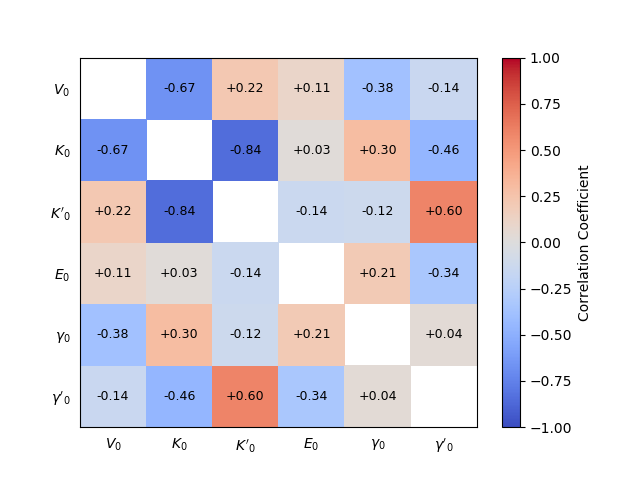

In [14]:
plt.figure()

posterior = datamodel['posterior']
corr = posterior['corr']

param_labels = [param_tex_str[name] for name in posterior['param_names']]


cmap = plt.get_cmap('coolwarm')
Nparam = len(param_labels)

corr_plt = np.flipud(np.ma.masked_where(np.eye(Nparam),corr))
plt.pcolormesh(corr_plt,cmap=cmap)


# plt.imshow(corr, cmap=cmap)
plt.clim(-1,1)
plt.colorbar(label=r'Correlation Coefficient')

plt.xticks(.5+np.arange(len(param_labels)),param_labels)
plt.yticks(np.flipud(.5+np.arange(len(param_labels))),param_labels)

for (index,val) in np.ndenumerate(np.flipud(corr)):
    if index[1]!=Nparam-1-index[0]:
        plt.text(index[1]+.5,index[0]+.5,'%+.2f'%(val),fontsize=9,
                 horizontalalignment='center', verticalalignment='center')

plt.setp(plt.gca().get_xticklines(),visible=False);
plt.setp(plt.gca().get_yticklines(),visible=False);

#plt.plot((0,11),(5,5),'k-',linewidth=2)
#plt.plot((0,11),(7,7),'k-',linewidth=2)
#plt.plot((4,4),(0,11),'k-',linewidth=2)
#plt.plot((6,6),(0,11),'k-',linewidth=2)
#plt.show()

In [15]:
from collections import OrderedDict
eos_mod = datamodel['eos_mod']
Tref = 1673
Vref = eos_mod.volume(0,Tref)
refvals = OrderedDict()
refvals['Vref'] = Vref
refvals['Kref'] = eos_mod.bulk_mod(Vref,Tref)
refvals['Cvref'] = eos_mod.heat_capacity(Vref,Tref)/models.CONSTS['kboltz']
display(refvals)

OrderedDict([('Vref', array([ 13.01903699])),
             ('Kref', array([ 15.03748061])),
             ('Cvref', array([ 4.24954775]))])

In [16]:
# datamod.fit(datamodel, apply_bulk_mod_wt=True)

<IPython.core.display.Javascript object>


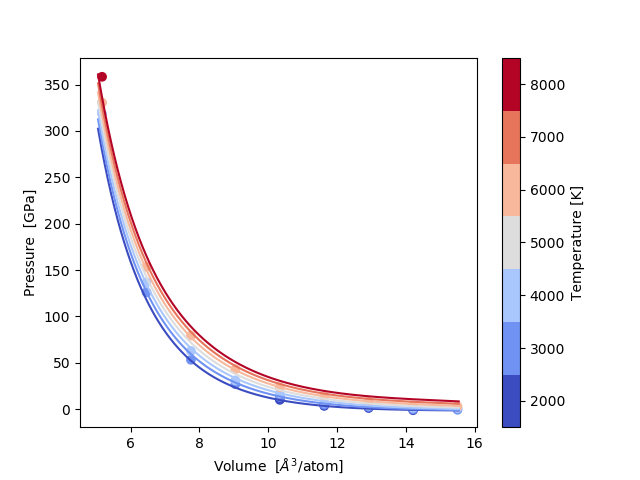

In [17]:
# Set colorbar temperature properties
cmap = plt.get_cmap('coolwarm',len(data['T_labels']))
delT = np.diff(data['T_labels'])[0]
Vmod = V0*np.linspace(.39,1.2,1001)


plt.figure()
plt.scatter(tbl['V'],tbl['P'],c=tbl['T'], cmap=cmap)

for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.press(Vmod,iT),'-',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)


<IPython.core.display.Javascript object>


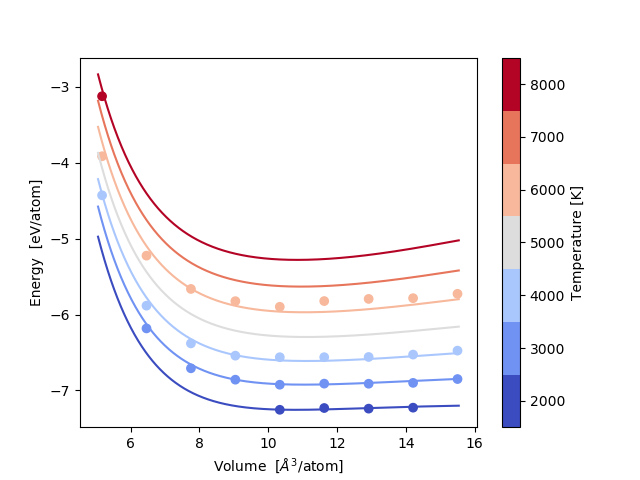

In [18]:
plt.figure()
plt.scatter(tbl['V'],tbl['E'],c=tbl['T'], cmap=cmap)


for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.internal_energy(Vmod,iT),'-',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

In [19]:
def material_properties(Pref, Tref, eos_mod, Vref=None):
    if Vref is None:
        Vref = eos_mod.volume(Pref, Tref, Vinit=12.8)[0]
        
    KT = eos_mod.bulk_mod(Vref,Tref)[0]
    CV = eos_mod.heat_capacity(Vref,Tref)
    alpha =  eos_mod.thermal_exp(Vref,Tref)[0]
    gamma =  eos_mod.gamma(Vref,Tref)[0]
    KS = KT*(1+alpha*gamma*Tref)
    props = OrderedDict()
    props['P'] = Pref
    props['T'] = Tref
    props['V'] = Vref
    props['KT'] = KT
    props['KS'] =  KS
    props['Cv'] = CV/CONSTS['kboltz']
    props['therm_exp'] = alpha
    props['gamma'] = gamma
    return props

model_props = material_properties(0,1673, eos_mod)
display(model_props)

OrderedDict([('P', 0),
             ('T', 1673),
             ('V', 13.019037909597685),
             ('KT', 15.037471603260855),
             ('KS', 15.636784467065795),
             ('Cv', array([ 4.24954781])),
             ('therm_exp', 8.4494319541361518e-05),
             ('gamma', 0.28193911074588729)])

In [20]:
display(analysis['props_Lange'])
display(analysis['props_Ghiorso'])

{'KT': 19.3500111762087,
 'P': 0,
 'T': 1673,
 'V': 12.803751383249672,
 'alpha': 8.481830207765933e-05,
 'betaT': 0.05167955671413378,
 'dVdT': 0.001635}

{'KS': 20.850204971850488,
 'P': 0,
 'T': 1673,
 'V': 12.860873922038328,
 'alpha': 0.0001005551969012266,
 'betaS': 0.047961159199637761,
 'c': 2835.855,
 'rho': 2592.6404131697873}

In [21]:
# Save fitted model
analysis['datamodel_dK09'] = datamodel
with open(analysis_file, 'wb') as f:
    pickle.dump(analysis, f)